In [1]:
import pandas as pd
import numpy as np
import uci_dataset as database
import torch

from raimitigations.utils import train_model_plot_results, split_data
import raimitigations.dataprocessing as dp

# Case Study 3

## Fixing a seed

To avoid randomness in the following experiments, we'll fix the seeds to guarantee that the results obtained are the same each time we run this notebook. Feel free to comment the next cell or test different seeds to see how this affects the results.

In [2]:
import random
SEED = 45
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## 1 - Understanding the Data

Case study 3 examines the thyroid disease dataset. We will explore how this dataset with the `dataprocessing` library.

In [3]:
df = database.load_thyroid_disease()
label_col = "sick-euthyroid"
df

,sick-euthyroid,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,sick-euthyroid,72.0,M,f,f,f,f,f,f,f,...,y,1.0,y,83.0,y,0.95,y,87.0,n,NaN
1,sick-euthyroid,45.0,F,f,f,f,f,f,f,f,...,y,1.0,y,82.0,y,0.73,y,112.0,n,NaN
2,sick-euthyroid,64.0,F,f,f,f,f,f,f,f,...,y,1.0,y,101.0,y,0.82,y,123.0,n,NaN
3,sick-euthyroid,56.0,M,f,f,f,f,f,f,f,...,y,0.8,y,76.0,y,0.77,y,99.0,n,NaN
4,sick-euthyroid,78.0,F,t,f,f,f,t,f,f,...,y,0.3,y,87.0,y,0.95,y,91.0,n,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3158,negative,40.0,F,f,f,f,f,f,f,f,...,y,1.2,y,76.0,y,0.90,y,84.0,n,NaN
3159,negative,69.0,F,f,f,f,f,f,f,f,...,y,1.8,y,126.0,y,1.02,y,124.0,n,NaN
3160,negative,58.0,F,f,f,f,f,f,f,f,...,y,1.7,y,86.0,y,0.91,y,95.0,n,NaN
3161,negative,29.0,F,f,f,f,f,f,f,f,...,y,1.8,y,99.0,y,1.01,y,98.0,n,NaN


In [4]:
df[label_col] = df[label_col].replace({"sick-euthyroid": 1, "negative": 0})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3163 entries, 0 to 3162
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sick-euthyroid             3163 non-null   int64  
 1   age                        2717 non-null   float64
 2   sex                        3090 non-null   object 
 3   on_thyroxine               3163 non-null   object 
 4   query_on_thyroxine         3163 non-null   object 
 5   on_antithyroid_medication  3163 non-null   object 
 6   thyroid_surgery            3163 non-null   object 
 7   query_hypothyroid          3163 non-null   object 
 8   query_hyperthyroid         3163 non-null   object 
 9   pregnant                   3163 non-null   object 
 10  sick                       3163 non-null   object 
 11  tumor                      3163 non-null   object 
 12  lithium                    3163 non-null   object 
 13  goitre                     3163 non-null   objec

In [6]:
df['query_on_thyroxine'].value_counts()

f    3108
t      55
Name: query_on_thyroxine, dtype: int64

The dataset is imbalanced, as most patients in the dataset do not have thyroid disease.

In [7]:
counts = df['query_on_thyroxine'].value_counts().values
counts

array([3108,   55])

In [8]:
cor_feat = dp.CorrelatedFeatures(
					method_num_num=["spearman", "pearson", "kendall"],				# Used for Numerical x Numerical correlations
					num_corr_th=0.9,												# Used for Numerical x Numerical correlations
					num_pvalue_th=0.05,												# Used for Numerical x Numerical correlations
					method_num_cat="model",											# Used for Numerical x Categorical correlations
					model_metrics=["f1", "auc"],									# Used for Numerical x Categorical correlations
					metric_th=0.9,													# Used for Numerical x Categorical correlations
					cat_corr_th=0.9,												# Used for Categorical x Categorical correlations
					cat_pvalue_th=0.01,												# Used for Categorical x Categorical correlations
					json_summary="./corr_json/c3_summary.json",
					json_corr="./corr_json/c3_corr.json",
					json_uncorr="./corr_json/c3_uncorr.json"
				)
cor_feat.fit(df=df, label_col=label_col)

Remember to look through the JSON files generated in the previous cell. Correlations have been found, which can be seen in `c3_corr.json`.

## 2 - Basic Pre-Processing

### Encode Categorical Variables
The dataset contains a number of columns that are categorical. `EncoderOHE` is used to perform One Hot Encoding on the dataset.

In [9]:
# Encode the categorical columns using One-Hot Encoding
enc_ohe = dp.EncoderOHE()
enc_ohe.fit(df)
proc_df = enc_ohe.transform(df)
proc_df

No columns specified for encoding. These columns have been automatically identfied as the following:
['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'thyroid_surgery', 'query_hypothyroid', 'query_hyperthyroid', 'pregnant', 'sick', 'tumor', 'lithium', 'goitre', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured']


,sick-euthyroid,age,TSH,T3,TT4,T4U,FTI,TBG,sex_M,sex_nan,...,sick_t,tumor_t,lithium_t,goitre_t,TSH_measured_y,T3_measured_y,TT4_measured_y,T4U_measured_y,FTI_measured_y,TBG_measured_y
0,1,72.0,NaN,1.0,83.0,0.95,87.0,NaN,1,0,...,0,0,0,0,0,1,1,1,1,0
1,1,45.0,1.90,1.0,82.0,0.73,112.0,NaN,0,0,...,0,0,0,0,1,1,1,1,1,0
2,1,64.0,0.09,1.0,101.0,0.82,123.0,NaN,0,0,...,1,0,0,0,1,1,1,1,1,0
3,1,56.0,0.00,0.8,76.0,0.77,99.0,NaN,1,0,...,0,0,0,0,1,1,1,1,1,0
4,1,78.0,2.60,0.3,87.0,0.95,91.0,NaN,0,0,...,0,0,0,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3158,0,40.0,2.10,1.2,76.0,0.90,84.0,NaN,0,0,...,1,0,0,0,1,1,1,1,1,0
3159,0,69.0,2.60,1.8,126.0,1.02,124.0,NaN,0,0,...,0,0,0,0,1,1,1,1,1,0
3160,0,58.0,5.80,1.7,86.0,0.91,95.0,NaN,0,0,...,0,0,0,0,1,1,1,1,1,0
3161,0,29.0,0.80,1.8,99.0,1.01,98.0,NaN,0,0,...,0,0,0,0,1,1,1,1,1,0


### Impute Missing Data

A number of features contain missing values. We will use `BasicImputer` to fill these values with -1

In [10]:
proc_df.isna().sum()

sick-euthyroid                    0
age                             446
TSH                             468
T3                              695
TT4                             249
T4U                             248
FTI                             247
TBG                            2903
sex_M                             0
sex_nan                           0
on_thyroxine_t                    0
query_on_thyroxine_t              0
on_antithyroid_medication_t       0
thyroid_surgery_t                 0
query_hypothyroid_t               0
query_hyperthyroid_t              0
pregnant_t                        0
sick_t                            0
tumor_t                           0
lithium_t                         0
goitre_t                          0
TSH_measured_y                    0
T3_measured_y                     0
TT4_measured_y                    0
T4U_measured_y                    0
FTI_measured_y                    0
TBG_measured_y                    0
dtype: int64

In [11]:
imputer = dp.BasicImputer(numerical={'missing_values':np.nan,
									'strategy':'constant',
									'fill_value':-1})
imputer.fit(proc_df)
proc_df = imputer.transform(proc_df)

No columns specified for imputation. These columns have been automatically identified:
['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']


### Split Dataset

In [12]:
train_x, test_x, train_y, test_y = split_data(proc_df, label_col, test_size=0.25)

## 2 - Baseline Models

In this example, we have an imbalanced dataset (most patients do not have thyroid disease). While we will take a look at a number of different metrics, we will be focused on improved the F1 score for this dataset.

After splitting the data into train and test sets, we will build two baseline models, one with XGBoost, and the other with KNN.


TEST SET:

[[704  14]
 [  9  64]]


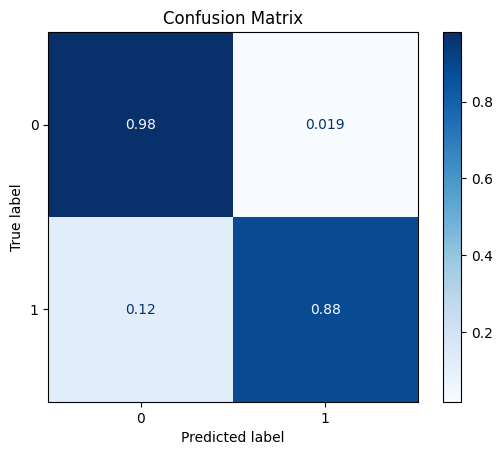

ROC AUC: 0.9617182432174611
Precision: 0.9039450498076024
Recall: 0.9286068607623916
F1: 0.9158047213776316
Accuracy: 0.9709228824273072
Optimal Threshold (ROC curve): 0.29627740383148193
Optimal Threshold (Precision x Recall curve): 0.37958627939224243
Threshold used: 0.29627740383148193


In [13]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False, plot_pr=False)


TEST SET:

[[536 182]
 [ 27  46]]


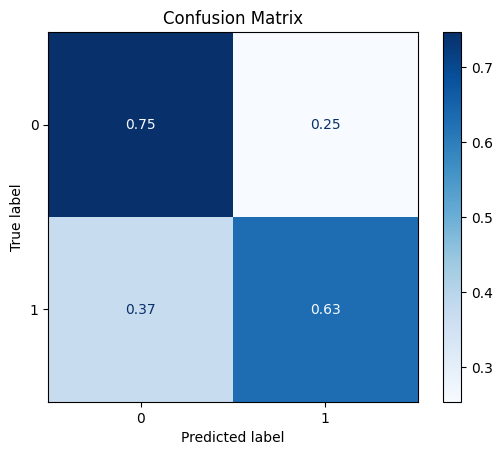

ROC AUC: 0.7110218643873774
Precision: 0.5768985073696675
Recall: 0.6883275460754761
F1: 0.5712470272134779
Accuracy: 0.7357774968394437
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [14]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="knn", train_result=False, plot_pr=False)

## 3 - Data Transformation

We will perform a number of different feature transformations, using the Scalers from `dataprocessing`.

### DataMinMaxScaler

The first data transformation we will perform is a MinMaxScaler, which will scale each feature to have a range between zero and one


TEST SET:

[[611 107]
 [ 13  60]]


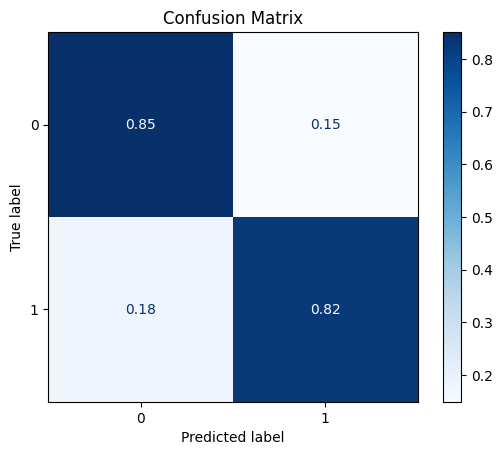

ROC AUC: 0.8665528293967262
Precision: 0.6692240518962076
Recall: 0.8364463692906475
F1: 0.7052906110283159
Accuracy: 0.8482932996207333
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [15]:
scaler = dp.DataMinMaxScaler()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataNormalizer

Next we try `DataNormalizer`, which will scale the vectors to have unit norm (i.e. vector of length one). This is often used in text classification, but we will use it here as well. 

No columns specified for imputation. These columns have been automatically identified:
[]

TEST SET:

[[541 177]
 [ 26  47]]


/home/matheus/Dropbox/Matheus/Microsoft_Research/Code/ResponsibleAI/ResponsibleAI/git/responsible-ai-toolbox-mitigations/raimitigations/utils/metric_utils.py:185: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


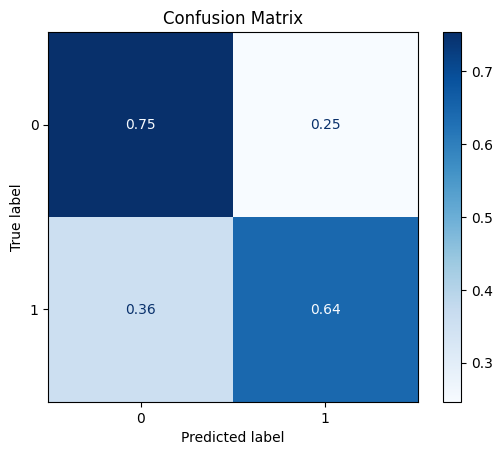

ROC AUC: 0.7177090090433853
Precision: 0.581983024691358
Recall: 0.698658755294387
F1: 0.5792608314009092
Accuracy: 0.7433628318584071
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 1.0
Threshold used: 0.2


In [16]:
scaler = dp.DataNormalizer()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataQuantileTransformer

The Quantile Transformer transforms the each feature to have a normal distribution.


TEST SET:

[[598 120]
 [  9  64]]


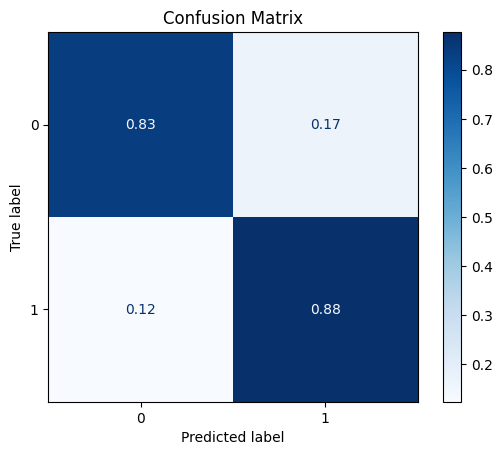

ROC AUC: 0.8824836875643911
Precision: 0.6664995344173054
Recall: 0.8547907047735337
F1: 0.7003479920710668
Accuracy: 0.8369152970922883
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [17]:
scaler = dp.DataQuantileTransformer()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataRobustScaler

The robust scaler centers the data (median=zero) and scales the data based on the interquartile range (IQR).


TEST SET:

[[611 107]
 [  9  64]]


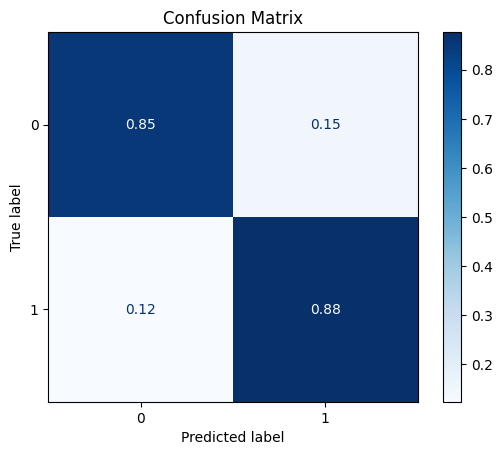

ROC AUC: 0.8919468081047048
Precision: 0.6798764384078475
Recall: 0.8638436295646201
F1: 0.7189468009507707
Accuracy: 0.8533501896333755
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [18]:
scaler = dp.DataRobustScaler()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataPowerTransformer

The power transformer makes the data more Gaussian-like (by default using the Yeo-Johnson transform).


TEST SET:

[[590 128]
 [ 11  62]]


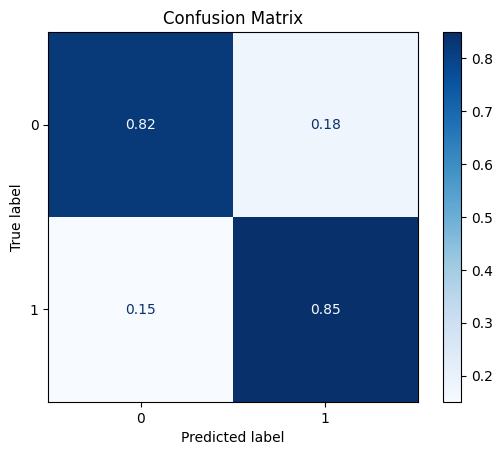

ROC AUC: 0.8798221849124279
Precision: 0.654006480427358
Recall: 0.8355210439958789
F1: 0.6830500119632053
Accuracy: 0.8242730720606827
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [19]:
scaler = dp.DataPowerTransformer()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

### DataStandardScaler

The standard scaler sets the mean to zero and scales the vectors to have unit variance.


TEST SET:

[[605 113]
 [  8  65]]


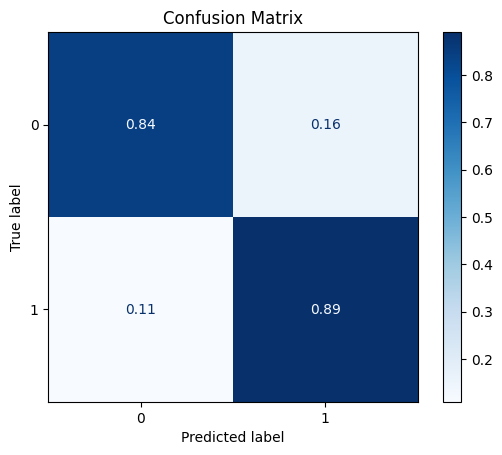

ROC AUC: 0.9002842751936504
Precision: 0.6760589841816815
Recall: 0.866514671652612
F1: 0.7135095979717494
Accuracy: 0.8470290771175727
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [20]:
scaler = dp.DataStandardScaler()
scaler.fit(train_x)
train_x_scl = scaler.transform(train_x)
test_x_scl = scaler.transform(test_x)
model = train_model_plot_results(train_x_scl, train_y, test_x_scl, test_y, model="knn", train_result=False, plot_pr=False)

From the previous results, we can see that the **DataStandardScaler** managed to get a considerable improvement over the baseline model. We'll use this scaled dataset in the following experiments.

## 4 - Feature Selection

Next, we perform a feature selection, which removes features from the dataset.

In [21]:
feat_sel = dp.CatBoostSelection(steps=5, verbose=False)
feat_sel.fit(X=train_x_scl, y=train_y)
train_x_sel = feat_sel.transform(train_x_scl)
test_x_sel = feat_sel.transform(test_x_scl)

/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/catboost/core.py:1222: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


In [22]:
feat_sel.get_selected_features()

['age',
 'TSH',
 'T3',
 'TT4',
 'FTI',
 'TBG',
 'sex_nan',
 'on_thyroxine_t',
 'on_antithyroid_medication_t',
 'thyroid_surgery_t',
 'query_hypothyroid_t',
 'query_hyperthyroid_t',
 'pregnant_t',
 'sick_t',
 'lithium_t',
 'goitre_t',
 'T3_measured_y']

We can see that we managed to remove a considerable amount of features from the dataset. Now, let's see if we manage to get any improvement in the metrics.


TEST SET:

[[626  92]
 [  9  64]]


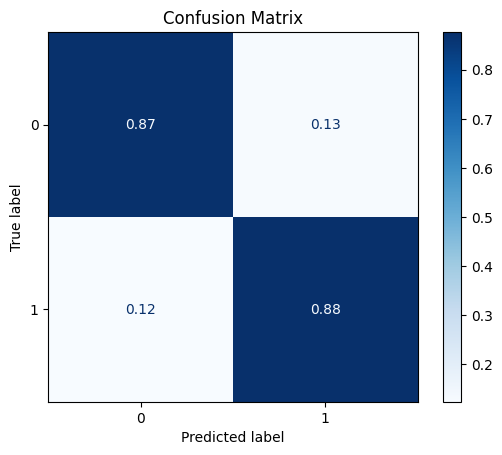

ROC AUC: 0.907124050826115
Precision: 0.6980415909549768
Recall: 0.8742893120158737
F1: 0.7421515183790186
Accuracy: 0.8723135271807838
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [23]:
model = train_model_plot_results(train_x_sel, train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

We can see that the **CatBoostSelection** class managed to improve even further the results obtained with the scaled data, where we have a higher F1 score and a similar ROC AUC. Note that we are now using a lot less data, since we removed several features from the dataset.

## 5 - Synthetic Data

Since we have an imbalanced dataset, we can generate instances of the minority class to improve the balance between the classes. Below, we increase the quantity of minority instances (patients with disease) from 220 to 400.

### imblearn Library

In [24]:
train_y.value_counts()

0    2152
1     220
Name: sick-euthyroid, dtype: int64

In [25]:
rebalance = dp.Rebalance(
				X=train_x_sel,
				y=train_y,
				strategy_over={0:2152, 1:400},
				over_sampler=True,
				under_sampler=False
			)
train_x_res, train_y_res = rebalance.fit_resample()
train_y_res.value_counts()

No columns specified for imputation. These columns have been automatically identified:
[]
Running oversampling...
...finished


0    2152
1     400
Name: sick-euthyroid, dtype: int64


TEST SET:

[[623  95]
 [  8  65]]


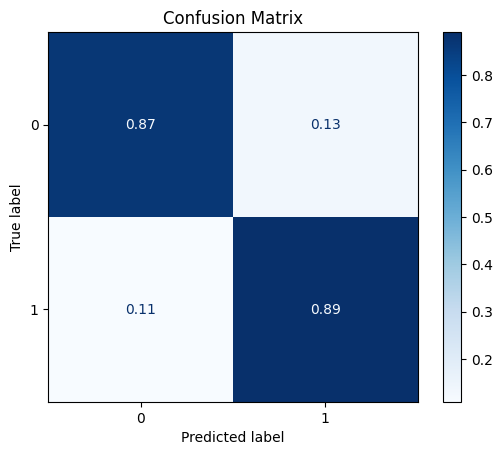

ROC AUC: 0.9110542984698745
Precision: 0.696785855784469
Recall: 0.8790494905941161
F1: 0.7407935300985947
Accuracy: 0.8697850821744627
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [26]:
model = train_model_plot_results(train_x_res, train_y_res, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

Notice that the **Rebalance** class managed to slightly improve the ROC AUC compared to the feature selection step, while maintaining a similar F1 score.

### Creating Artificial Data using Deep Learning

#### CTGAN

In [27]:
synth = dp.Synthesizer(
				X=train_x_sel,
				y=train_y,
				epochs=200,
				model="ctgan",
				load_existing=False
			)
synth.fit()

conditions = {label_col:1}	# create more of the undersampled class
syn_train_x, syn_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=200, conditions=conditions)

syn_train_y.value_counts()

/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.wa

0    2152
1     420
Name: sick-euthyroid, dtype: int64


TEST SET:

[[580 138]
 [  7  66]]


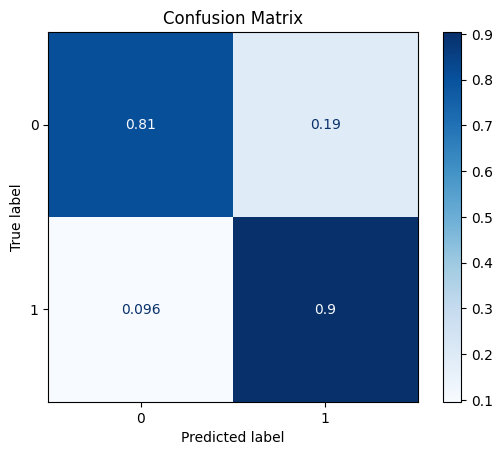

ROC AUC: 0.9070572747739154
Precision: 0.6558021845876341
Recall: 0.8559545159690158
F1: 0.6827115924588849
Accuracy: 0.8166877370417194
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [28]:
model = train_model_plot_results(syn_train_x, syn_train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

Sampling conditions:   0%|          | 0/600 [00:00<?, ?it/s]/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sdv/tabular/base.py:608: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group, dataframe in grouped_conditions:
/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sdv/tabular/base.py:639: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for transformed_group, transformed_dataframe in transformed_groups:
/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/ctgan/data_transformer.py:149: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always 


TEST SET:

[[537 181]
 [  5  68]]


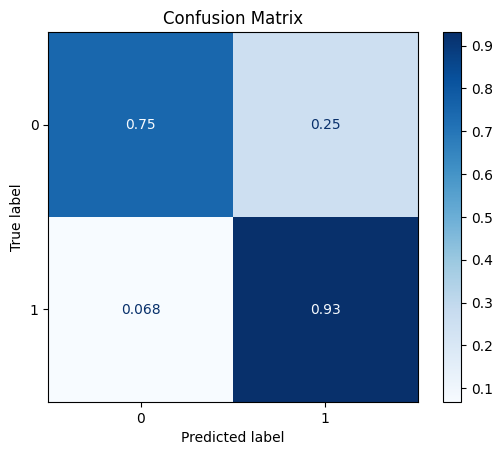

ROC AUC: 0.9090414774678521
Precision: 0.6319336386134946
Recall: 0.8397088564124089
F1: 0.6373706004140787
Accuracy: 0.7648546144121365
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.6
Threshold used: 0.2


In [29]:
conditions = {label_col:1}	# create more of the undersampled class
syn_train_x, syn_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=600, conditions=conditions)

model = train_model_plot_results(syn_train_x, syn_train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

#### TVAE

Finally, we generate artificial instances using TVAE (a variational auto encoder for generating tabular data).

In [30]:
synth = dp.Synthesizer(
				X=train_x_sel,
				y=train_y,
				epochs=200,
				model="tvae",
				load_existing=False
			)
synth.fit()

conditions = {label_col:1}	# create more of the undersampled class
syn2_train_x, syn2_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=200, conditions=conditions)

/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/matheus/miniconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.wa


TEST SET:

[[606 112]
 [  9  64]]


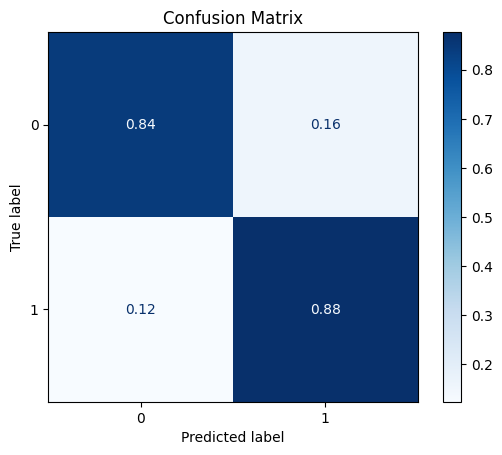

ROC AUC: 0.9024497271721296
Precision: 0.6745011086474502
Recall: 0.8603617354142024
F1: 0.7116417658631524
Accuracy: 0.8470290771175727
Optimal Threshold (ROC curve): 0.2
Optimal Threshold (Precision x Recall curve): 0.4
Threshold used: 0.2


In [31]:
model = train_model_plot_results(syn2_train_x, syn2_train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)